## 相关包的引入

In [1]:
import numpy as np # linear computation
import pandas as pd # data processing, CSV file I/O
from skimage.data import imread # read image
import matplotlib.pyplot as plt # plot
import os # path
from pathlib import Path
PATH = 'F:/[Base] Code/DataSets/airbus-ship-detection'

## 查看数据集格式
&emsp;&emsp;大多数带标签数据集都以csv（表格）格式呈现，如下图所示，利用pandas包读取csv数据集得到数据表，格式为tuple（obj, features），这里即图片（ImageId）和图片对应的船只位置信息（EncodeedPixels）

In [5]:
train = pd.read_csv(PATH + '/train_ship_segmentations_v2.csv')
train.sample(3)

,ImageId,EncodedPixels
168038,b95d7e978.jpg,NaN
136569,96bbbb8b8.jpg,118372 1 119138 4 119905 5 120672 7 121438 10 ...
107214,75fe4b3c8.jpg,NaN


&emsp;&emsp;因为图片的位置信息编码格式为run-length编码（目的是压缩以减小传输尺寸，一般较大的数据集的标签都不会完整呈现给我们而是以一种压缩编码的方式呈现，我们需要将其解码才能得到完整信息，以下为rle解码）

In [21]:
# reference: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

## 图片展示（有船）

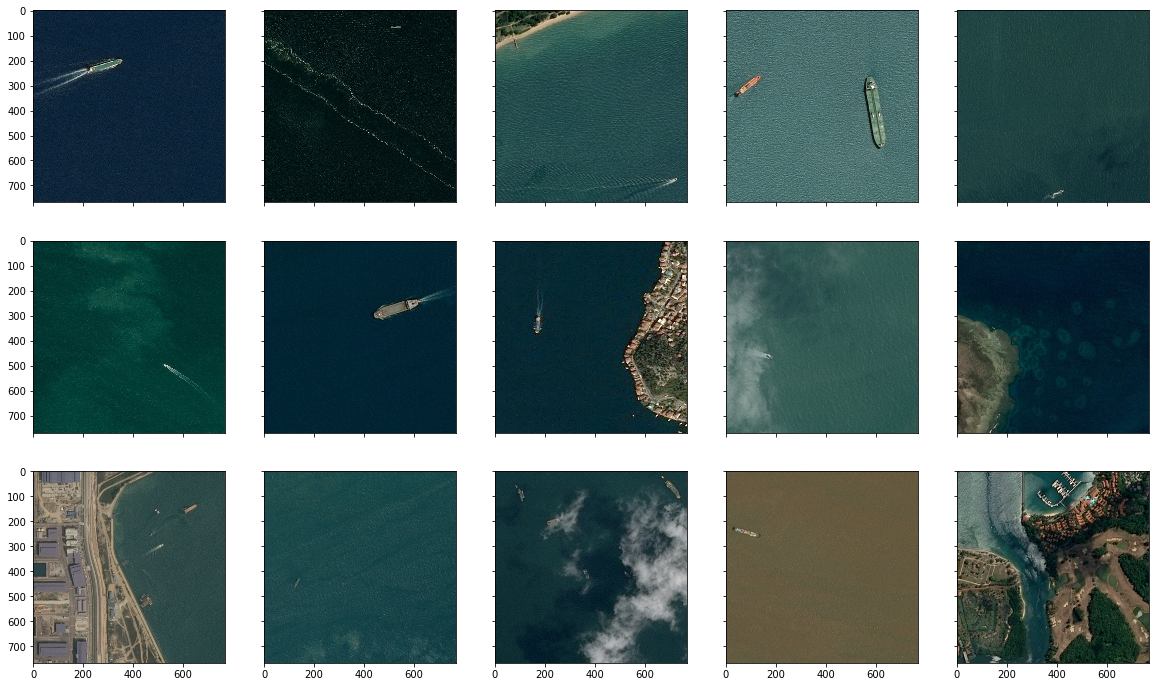

In [27]:
sample = train[~train.EncodedPixels.isna()].sample(15)

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 12)

for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path(PATH + '/train_v2') / '{}'.format(imgid)
    img = imread(path)
    
    ax[row, col].imshow(img)

## RLE解码信息

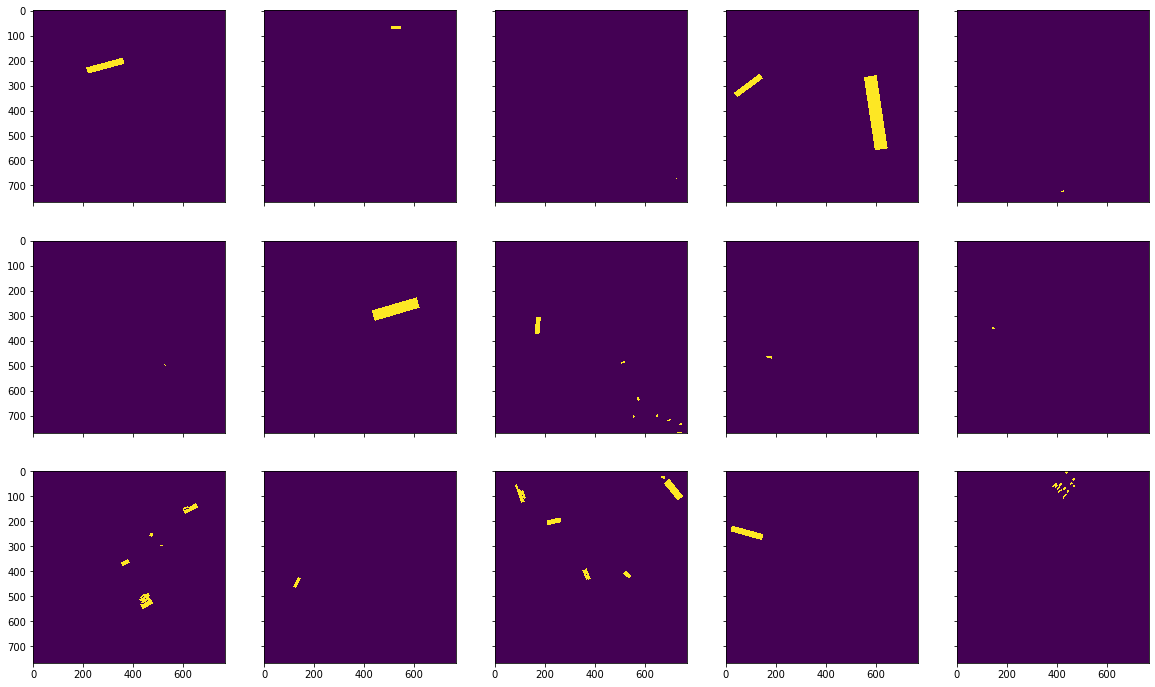

In [49]:
masks = pd.read_csv(PATH + '/train_ship_segmentations_v2.csv')
fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 12)
all_masks = np.zeros((768, 768)) # purple
for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    img = imread(PATH + '/train_v2/' + imgid)
    img_masks = masks.loc[masks['ImageId'] == imgid, 'EncodedPixels'].tolist()
    for mask in img_masks:
        all_masks += rle_decode(mask)
    ax[row, col].imshow(all_masks)
    all_masks = np.zeros((768, 768))

&emsp;&emsp;我们随机抽选了15张有船的图片（可重复随机抽选），解码后图片为根据数据集标签得出的船只像素位置。我们发现部分船只的位置信息是很清晰的，解码后的黄色区域也是独立且清晰，但部分图片存在船只过小或不清楚的情况，对应至解码后图片的表现为过小的船只以点状分布，有的稀疏有的密集，特征混乱且不明显；此外大小不一的船只解码区域的交界处也不明显，存在重叠现象

## 图片展示（无船）

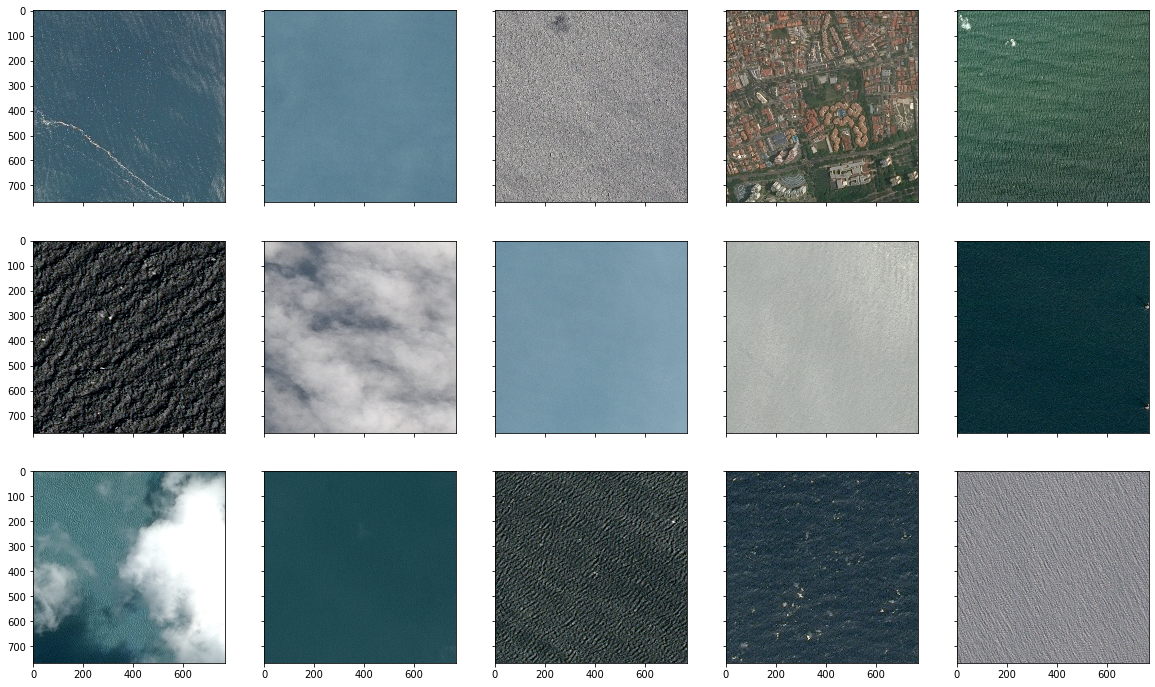

In [25]:
sample = train[train.EncodedPixels.isna()].sample(15)

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 12)

for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path(PATH + '/train_v2') / '{}'.format(imgid)
    img = imread(path)
    
    ax[row, col].imshow(img)

&emsp;&emsp;我们再随机抽选15张无船的图片，可以看到有没有干扰的图片（纯色海水，大片白云），但也存在干扰较为明显的图片（云层，港口，縠纹），这对我们检测船只的特征增加了难度

## 数据集类型比较

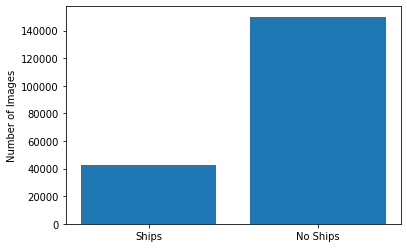

In [17]:
ships = train[~train.EncodedPixels.isna()].ImageId.unique()
noships = train[train.EncodedPixels.isna()].ImageId.unique()

plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)]);
plt.ylabel('Number of Images');

&emsp;&emsp;可以看出无船的负样本数目远大于有船的数目，因此有必要在训练前对样本分布进行处理

## 单图片船只数目统计

In [52]:
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_df = pd.merge(masks, unique_img_ids)
print(train_df.shape[0], 'training masks')
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(
    c_row['EncodedPixels'], str
) else 0, 1)
train_df.head()

231723 training masks


,ImageId,EncodedPixels,counts
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5


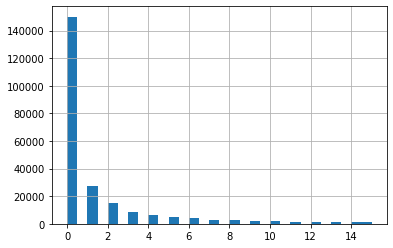

In [54]:
train_df['counts'].hist(bins = 30)

&emsp;&emsp;可以看出，约有十五万张没有船只的负样本，这占据了绝大部分样本空间；剩下的有船图片里，单单船和双船模型占据了绝大部分的空间，而多船模型在样本空间内仅占一小部分。我们的特征学习主要来源于有船样本标签提供的特征，因此在排除无船样本的前提下，我们的重心可以放在单船和双船模型的检测上，所以样本均衡是之后必不可少的一个环节

## 图片颜色特征分布

In [18]:
def get_img(imgid):
    '''Return image array, given ID'''
    path = Path(PATH + '/train_v2') / '{}'.format(imgid)
    return imread(path)

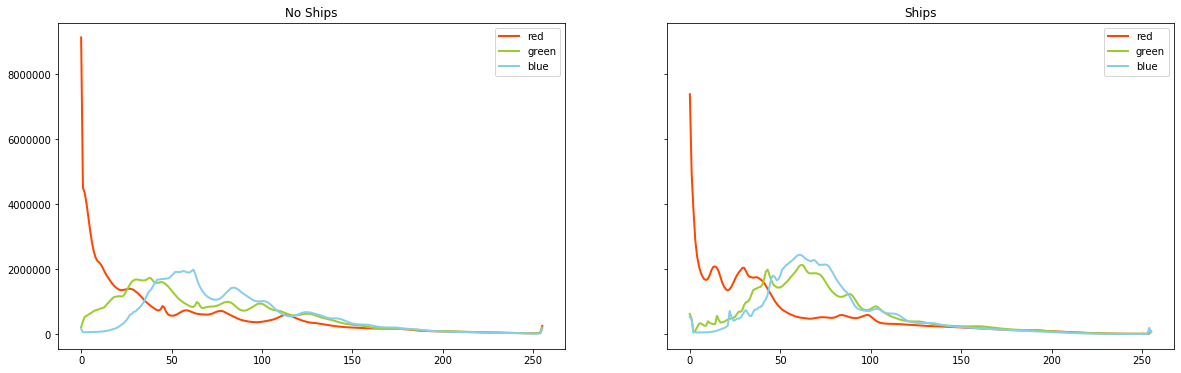

In [19]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_size_inches(20, 6)

mask = train.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = train[msk].ImageId.sample(250)
    imgs = np.array([get_img(_id) for _id in _ids])
    
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    ax[i].plot(np.bincount(red.ravel()), color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel()), color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel()), color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)

&emsp;&emsp;除了标签提供的位置特征外，对于图像型数据来说，颜色特征是一个值得考虑的隐藏特征。经分析我们可以看出，有船和无船样本图片的颜色特征基本没有差别，因此我们排除了添加特征颜色作为识别的依据这一可能性

## 标签区域颜色特征分布

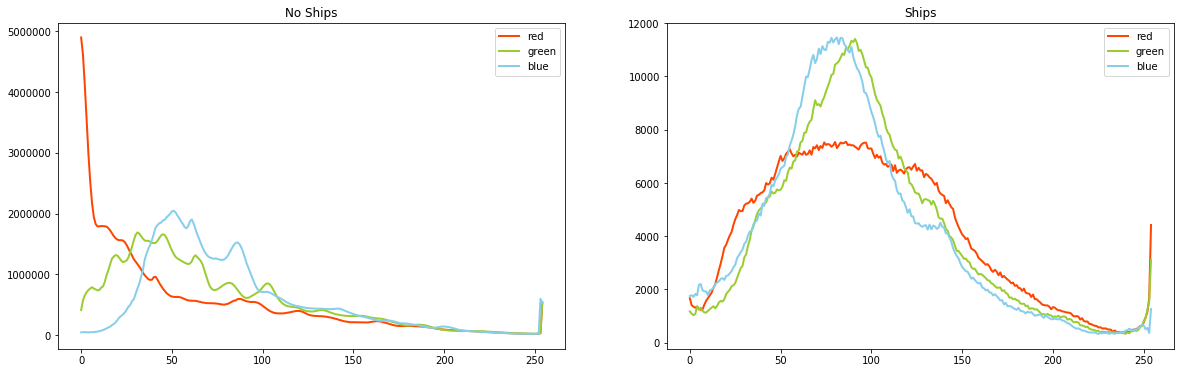

In [22]:
def apply_masks_to_img(img, _id, df):
    '''Apply masks to image given img, its id and the dataframe.'''
    masks = df[df.ImageId == _id].EncodedPixels.apply(lambda x: rle_decode(x)).tolist()
    masks = sum(masks)
    return img * masks.reshape(img.shape[0], img.shape[1], 1)


fig, ax = plt.subplots(1, 2, sharex='col')#, sharey='row')
fig.set_size_inches(20, 6)

mask = train.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = train[msk].ImageId.sample(250)
    imgs = [get_img(_id) for _id in _ids]
    
    # if we have an encoding to decode
    if i == 1:
        imgs = [apply_masks_to_img(i, _id, train) for (i, _id) in zip(imgs, _ids)]

    imgs = np.array(imgs)
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    # skip bincount index 0 to avoid the masked pixels to overpower the others.
    ax[i].plot(np.bincount(red.ravel())[1:], color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel())[1:], color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel())[1:], color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)

&emsp;&emsp;很明显，标签区域附近有船样本和无船样本的颜色特征差异较为明显，但是这里的颜色差异是由标签引起的，即有船图片标注的的船只部分颜色一定与无船图片有较大差异，这一部分的特征学习属于标签学习的范畴。至此，我们基本排除了以特征颜色为参考的可能性